In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import math

import category_encoders as ce

import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms

import vizualizacia_funkcie as visual

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import base
from sklearn import compose
from sklearn import feature_selection
from sklearn import model_selection

from datetime import datetime
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

import imblearn
import preprocessing_pipeline as prep_pip

# grafy
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku


# Predspracovanie validacneho datasetu a opis pripadnych zmien

In [2]:
df1 = pd.read_csv("./data/personal_train.csv", index_col=0)
df2 = pd.read_csv("./data/other_train.csv", index_col=0)

X, y = prep_pip.one_proper_df(df1, df2)

C:\Users\makoh\IAU\git_projekt\IAU\preprocessing_pipeline.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_dataset.iloc[0][attr] = not_null.values[0]


In [3]:
PIP = prep_pip.get_preprocessing_pipeline()

In [4]:
X_train, y_train = PIP.fit_predict(X, y)

In [5]:
print(X_train.shape)
print(y_train.shape)

(3254, 33)
(3254,)


In [6]:
X_train.columns

Index(['age', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen',
       'skewness_oxygen', 'mean_glucose', 'std_glucose', 'kurtosis_glucose',
       'skewness_glucose', 'sex_0', 'sex_1', 'marital-status_0',
       'marital-status_1', 'marital-status_2', 'marital-status_3',
       'relationship_0', 'relationship_1', 'relationship_2', 'relationship_3',
       'occupation_0', 'occupation_1', 'occupation_2', 'occupation_3',
       'occupation_4', 'occupation_5', 'occupation_6', 'occupation_7',
       'occupation_8', 'workclass_0', 'workclass_1', 'education',
       'hours-per-week-cat', 'income'],
      dtype='object')

# Pri praci s validacnym datasetom sa nepouziva fit_predict ale iba predict

In [7]:
df1 = pd.read_csv("./data/personal_valid.csv", index_col=0)
df2 = pd.read_csv("./data/other_valid.csv", index_col=0)

X, y = prep_pip.one_proper_df(df1, df2)

data = X
data["class"] = y


indices = data.loc[data["class"].isnull()].index.values

data = data.drop(index=indices)
data = data.reset_index(drop=True)

X = data.drop(columns=["class"])
y = data["class"]

C:\Users\makoh\IAU\git_projekt\IAU\preprocessing_pipeline.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_dataset.iloc[0][attr] = not_null.values[0]


In [8]:
X_valid = PIP.predict(X)
y_valid = y

In [9]:
print(X_valid.shape)
print(y_valid.shape)

(1303, 33)
(1303,)


# Manualne vytvorenie a vyhodnotenie rozhodovacich pravidiel pre klasifikaciu

In [10]:
medical_attributes = ['kurtosis_glucose', 'skewness_glucose', 'mean_glucose', 'std_glucose', 
                       'kurtosis_oxygen','skewness_oxygen', 'mean_oxygen', 'std_oxygen']

medical_data = X_train[medical_attributes]
medical_data["class"] = y_train

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Ideme hladat medical atributy ktore maju najvacsiu korelaciu s class atributom

In [11]:
medical_data.corr()

,kurtosis_glucose,skewness_glucose,mean_glucose,std_glucose,kurtosis_oxygen,skewness_oxygen,mean_oxygen,std_oxygen,class
kurtosis_glucose,1.000000,0.835325,-0.934560,-0.714519,-0.752050,-0.751751,0.782131,0.804809,0.833264
skewness_glucose,0.835325,1.000000,-0.871752,-0.867680,-0.657859,-0.661421,0.686865,0.719545,0.802770
mean_glucose,-0.934560,-0.871752,1.000000,0.707912,0.717437,0.717312,-0.744496,-0.773611,-0.828168
std_glucose,-0.714519,-0.867680,0.707912,1.000000,0.455566,0.462249,-0.482558,-0.505701,-0.579271
kurtosis_oxygen,-0.752050,-0.657859,0.717437,0.455566,1.000000,0.993711,-0.989776,-0.922936,-0.813903
skewness_oxygen,-0.751751,-0.661421,0.717312,0.462249,0.993711,1.000000,-0.988444,-0.937249,-0.820950
mean_oxygen,0.782131,0.686865,-0.744496,-0.482558,-0.989776,-0.988444,1.000000,0.940096,0.851477
std_oxygen,0.804809,0.719545,-0.773611,-0.505701,-0.922936,-0.937249,0.940096,1.000000,0.877938
class,0.833264,0.802770,-0.828168,-0.579271,-0.813903,-0.820950,0.851477,0.877938,1.000000


In [12]:
medical_attributes = ['kurtosis_glucose', 'mean_glucose', 'mean_oxygen', 'std_oxygen']

Medzi atributy s najvacsou korelaciou ku atributu target su:
- std_oxygen
- mean_oxygen
- kurtosis_glucose
- mean_glucose

Tieto atributy sme si zvolili na pracu s nasim manualne vytvorenym stromom

Korelacia medzi nasim atributom a y: 0.8332636111101277


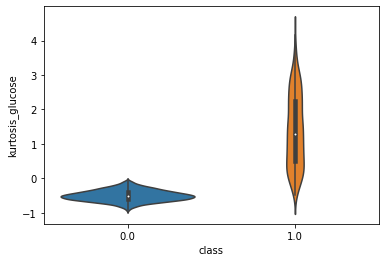

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


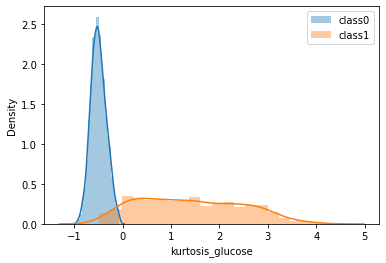

In [13]:
visual.univariate_num_to_class(medical_data, "kurtosis_glucose", show_regplot=False)

Korelacia medzi nasim atributom a y: -0.5792708486920812


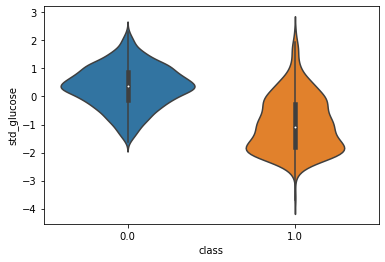

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


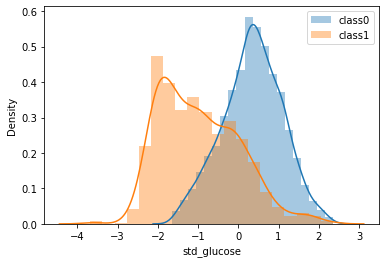

In [14]:
visual.univariate_num_to_class(medical_data, "std_glucose", show_regplot=False)

Korelacia medzi nasim atributom a y: 0.851476701566479


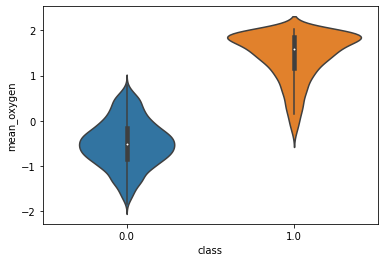

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


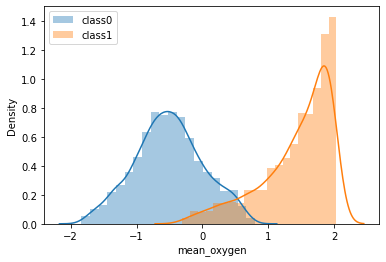

In [15]:
visual.univariate_num_to_class(medical_data, "mean_oxygen", show_regplot=False)

Korelacia medzi nasim atributom a y: 0.877937984221098


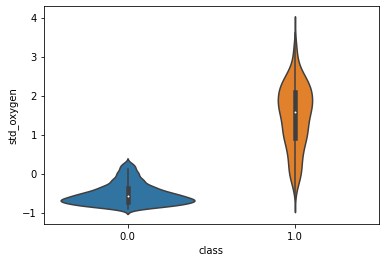

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


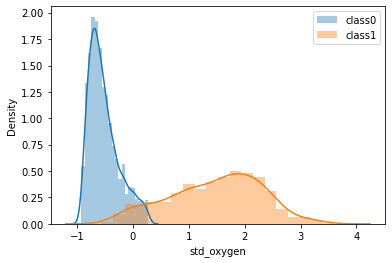

In [16]:
visual.univariate_num_to_class(medical_data, "std_oxygen", show_regplot=False)

S pozorovania vidime ze najvacsiu korelaciu dosahuju atributy kurtosis_glucose, skewness_glucose, mean_oxygen, std_oxygen

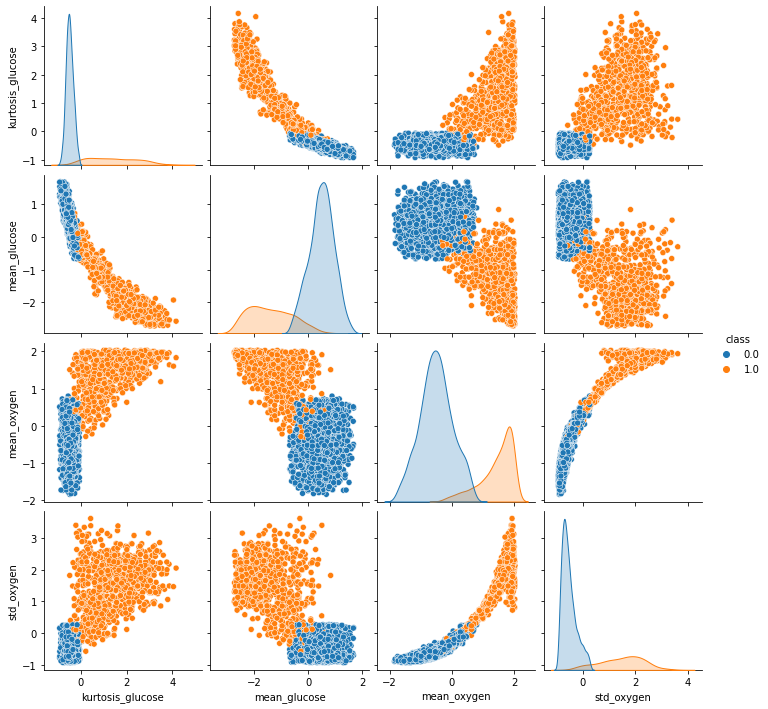

In [17]:
sns.pairplot(medical_data[['kurtosis_glucose', 'mean_glucose', 'mean_oxygen', 'std_oxygen','class']], hue = 'class')

# Nami vytvoreny strom

In [18]:
class Node:
    
    #budeme sa riadit, ze pravidla vyzeraju ATTR < X, kedy pokial je to pravda, ideme dolava
    def __init__(self, threshold=None, col_name=None, gini=None, leaf=True, root=False):
        
        self.root = root
    
        self.left = None
        self.right = None

        #atributy inner nodu
        self.col_name = col_name
        self.threshold = threshold
        
        
        
        #atributy leaf nodu
        self.predicition = None
        self.leaf = leaf
        self.gini = gini
    


In [19]:
#v nasom strome budeme pracovat len s ciselnymi atributmi
class DecisionTree:
    
    def __init__(self):
        self.root = Node(leaf=False, root=True)
        
    def fit(self, X, y, node=None):
        
        #uz nemame dataset
        if X.shape[1] == 0 or X.shape[0] == 0:
            return
        
        #pokial dany node ma gini impurity == 0, tak cely dataset ma rovnaku triedu
        if node is not None and node.gini == 0:
            return
        
        #hladanie optimalneho thresholdu
        attribute_name, threshold = self.best_threshold(X, y)
        
        #pokial najlepsi threshold je stale vacsi ako doterajsia impurita - teda sa neoplati uz dataset
        #splitovat, a teda koncime
        if node is not None and node.gini < threshold:
            return
        
        #splitneme dataset podla pravidla + vypocitame gini impurity pre konkretne children nody
        data = X
        data["class"] = y
        
        left_data = data.loc[data[attribute_name] < threshold]
        right_data = data.loc[data[attribute_name] >= threshold]
        
        #taktiez dropneme atribut, ktoremu sme uz vytvorili pravidlo
        left_data = left_data.drop(columns=[attribute_name])
        right_data = right_data.drop(columns=[attribute_name])
        
        #vypocitame gini impurity pre jednotlive children nody
        left_yes = len(left_data.loc[data["class"] == 1])
        left_no = len(left_data.loc[data["class"] == 0])
        
        right_yes = len(right_data.loc[data["class"] == 1])
        right_no = len(right_data.loc[data["class"] == 0])
        
        left_gini = 1 - (left_yes/len(left_data))**2 - (left_no/len(left_data))**2
        right_gini = 1 - (right_yes/len(right_data))**2 - (right_no/len(right_data))**2
        
    
        #chceme vypocitat, co children nody klasifikuju, pokial by zostali leaf nodami
        left_pred = 0
        right_pred = 0
        
        if left_yes >= left_no:
            left_pred = 1
        
        if right_yes >= right_no:
            right_pred = 1
         
        
        if node is None:
            node = self.root
            
        #pridanie atributov pre inner node - pravidlo
        node.threshold = threshold
        node.col_name = attribute_name
        node.leaf = False
        
        #vytvorime children nody
        node.left = Node()
        node.right = Node()
        
        #pridanie atributov pre leaf nody
        node.left.prediction = left_pred
        node.left.gini = left_gini
        
        node.right.prediction = right_pred
        node.right.gini = right_gini
    
            
        #rekurzivne vytvarame dalsie nody v strome
        
        #lavy podstrom
        self.fit(left_data.drop(columns=["class"]), left_data["class"], node.left)
        
        #pravy podstrom
        self.fit(right_data.drop(columns=["class"]), right_data["class"], node.right)
        
    
    def best_threshold(self, X, y):
        
        n_features = X.shape[1]
        col_names = X.columns.values
        
        print("hladanie najlepsich thresholdov s poctom atributov:", n_features)
        
        best_thresholds = np.zeros(n_features)
        
        best_ginis = np.ones(n_features)
        
        #hladame najlepsi threshold v kazdom atribute
        for i in range(n_features):
            
            print("ity feature:", i)
            
            data = X.copy()
            data["class"] = y.copy()
            
            data = data.sort_values(by=[col_names[i]], ascending=True)
            
            #hladame najlepsi threshold pre konkretny atribut
            for row in range(len(data)-1):
                
                thresh = (data.iloc[row][col_names[i]] + data.iloc[row+1][col_names[i]]) / 2
                impurity = self.get_gini(X, y, thresh, col_names[i])
                
                if impurity < best_ginis[i]:
                    best_thresholds[i] = thresh
                    best_ginis[i] = impurity
        
        #teraz vratime najlepsi threshold s najlepsich, spolu s nazvom stplca
        index = np.argmin(best_ginis)
        print("GINI:", best_ginis[index])
        return col_names[index], best_thresholds[index]
    
    def predict(self, X):
        predictions = np.zeros(len(X))
        
        for i in range(len(X)):
            predictions[i] = self.traverse_tree(X.iloc[i])
            
        return predictions
        
    
    def traverse_tree(self, x):
        node = self.root
        
        while node.leaf == False:
            col = node.col_name
            if x[col] < node.threshold:
                node = node.left
            else:
                node = node.right
        
        return node.prediction
    
    #vracia a zaroven vypisuje metriky v poradi accuracy, precision, recall, f1
    def score(self, valid_data):
        
        truth = valid_data["class"].values
        predictions = self.predict(valid_data.drop(columns=["class"]))
        
        TP = ((truth == 1) & (predictions == 1)).sum()
        FP = ((truth == 0) & (predictions == 1)).sum()
        TN = ((truth == 0) & (predictions == 0)).sum()
        FN = ((truth == 1) & (predictions == 0)).sum()
        
        accuracy = (TP+TN)/(len(truth))#+1e-9)
        precision = TP/(TP+FP)#+1e-9)
        recall = TP/(TP+FN)#+1e-9)
        f1 = 2 * (precision*recall) / (precision+recall)
        
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 score:", f1)
        
        return accuracy, precision, recall, f1
    
    def get_gini(self, X, y, thresh, col):
        
        data = X
        data["class"] = y
        
        left_data = data.loc[data[col] < thresh]
        right_data = data.loc[data[col] >= thresh]
        
        #neoplati sa nam splitovat dataset, pokial cely dataset sa presunie do ineho nodu, takze
        #automaticky dame gini = 2, aby sme nevybrali tento threshold
        if len(left_data) == 0 or len(right_data) == 0:
            return 2
        
        left_yes = len(left_data.loc[data["class"] == 1])
        left_no = len(left_data.loc[data["class"] == 0])
        
        right_yes = len(right_data.loc[data["class"] == 1])
        right_no = len(right_data.loc[data["class"] == 0])
        
        left_gini = 1 - (left_yes/len(left_data))**2 - (left_no/len(left_data))**2
        right_gini = 1 - (right_yes/len(right_data))**2 - (right_no/len(right_data))**2
        
        gini = (len(left_data) / len(X))*left_gini + (len(right_data)/len(X))*right_gini
        return gini
        

In [20]:
medical_train_ds = X_train[medical_attributes]
medical_train_ds['class'] = y_train

medical_valid_ds = X_valid[medical_attributes]
medical_valid_ds['class'] = y_valid

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [21]:
import warnings
warnings.filterwarnings('ignore')

import time

tree = DecisionTree()
tree.fit(medical_train_ds.drop(columns=["class"]), medical_train_ds["class"])

hladanie najlepsich thresholdov s poctom atributov: 4
ity feature: 0
ity feature: 1
ity feature: 2
ity feature: 3
GINI: 0.03246076807014266
hladanie najlepsich thresholdov s poctom atributov: 3
ity feature: 0
ity feature: 1
ity feature: 2
GINI: 0.020929056712439754


In [22]:
tree.score(medical_valid_ds)

Accuracy: 0.953184957789716
Precision: 0.9246987951807228
Recall: 0.8950437317784257
F1 score: 0.9096296296296296


(0.953184957789716, 0.9246987951807228, 0.8950437317784257, 0.9096296296296296)

# Natrenovanie a vyhodnotenie klasifikatora s vyuzitim rozhodovacich stromov

In [25]:
X_test = X_valid
y_test = y_valid

max_depth

Pozrieme sa na vztah hlbky stromu a accuracy.

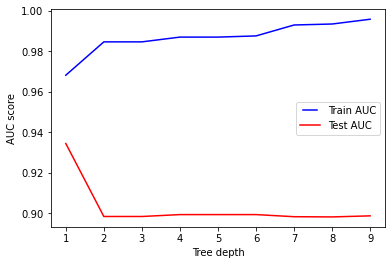

In [26]:
max_depths = np.linspace(1, 9, 9, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

Vidime ze nas model dosahuje pri trenovacom datasete najlepsie vysledky v hlbke 9 zatial co testovaci dosahuje najlepsi vysledok v hlbke 2.

min_samples_leafs

Definuje minimálne vzorky (alebo pozorovania) požadované v koncovom uzle alebo liste.


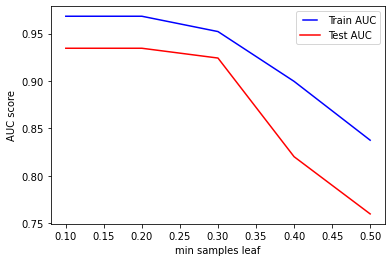

In [27]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

#### Metody pre automatizovane testovanie rozhodovacich stromov

Pri testovani sa budeme pozerat na metriky : Accuracy, Precision, Recall a F1 score

Accuracy :  predstavuje schopnosť modelu správne predpovedať pozitíva aj negatíva zo všetkých predpovedí. Matematicky predstavuje pomer súčtu skutočných pozitív a skutočných negatívov zo všetkých predpovedí.

Precision : predstavuje schopnosť modelu správne predpovedať pozitíva zo všetkých pozitívnych predpovedí, ktoré urobil. Skóre presnosti je užitočným meradlom úspešnosti predikcie, keď sú triedy veľmi nevyvážené. Matematicky predstavuje pomer skutočne pozitívneho k súčtu skutočných pozitívnych a falošných pozitív.

Recall : predstavuje schopnosť modelu správne predpovedať pozitíva zo skutočných pozitív. To je na rozdiel od presnosti, ktorá meria, koľko predpovedí vytvorených modelmi je skutočne pozitívnych zo všetkých vytvorených pozitívnych predpovedí. Skóre Recall je užitočným meradlom úspešnosti predikcie, keď sú triedy veľmi nevyvážené. Matematicky predstavuje pomer skutočne pozitívneho k súčtu skutočných pozitívnych a falošných negatívov.

F1 Score : predstavuje skóre modelu v závislosti od presnosti a skóre vyvolania. Toto je užitočné opatrenie modelu v scenároch, keď sa človek snaží optimalizovať buď presnosť alebo vyvolanie skóre, a vo výsledku tým trpí výkonnosť modelu.


In [28]:
def printMetrics(model):
    print('---------------------ACCURACY-----------------------')
    
    y_pred = model.predict(X_valid)
    print('Accuracy: ', accuracy_score(y_valid, y_pred))
    
    print('---------------------PRECISION----------------------')
    
    micro_precision = precision_score(y_pred, y_valid, average='micro')
    print('Micro-averaged precision: ', micro_precision)

    macro_precision = precision_score(y_pred, y_valid, average='macro')
    print('Macro-averaged precision: ', macro_precision)

    per_class_precision = precision_score(y_pred, y_valid, average=None)
    print('Per-class precision score:', per_class_precision)
    
    print('----------------------RECALL------------------------')
    
    micro_recall = recall_score(y_valid, y_pred, average='micro')
    print('Micro-averaged recall: ', micro_recall)

    macro_recall = recall_score(y_valid, y_pred, average='macro')
    print('Macro-averaged recall: ', macro_recall)

    per_class_recall = recall_score(y_valid, y_pred, average=None)
    print('Per-class recall score:', per_class_recall)
    
    print('----------------------F1-SCORE----------------------')
    
    micro_f1_score = f1_score(y_valid, y_pred, average='micro')
    print('Micro-averaged f1 score: ', micro_f1_score)

    macro_f1_score = f1_score(y_valid, y_pred, average='macro')
    print('Macro-averaged f1 score: ', macro_f1_score)

    per_class_f1_score = f1_score(y_valid, y_pred, average=None)
    print('Per-class f1 score:', per_class_f1_score)

Funkcia na vykreslenie stromu

In [29]:
def visualizeTree(model, X):
    graph = Source(export_graphviz(model, 
                               out_file=None,
                               feature_names=X.columns,
                               class_names=['no', 'yes'],
                               filled = True))

    display(SVG(graph.pipe(format='svg')))

    style = "<style>svg{width:70% !important;height:70% !important;}</style>"
    HTML(style)

Funkcia ktora nam ulahci testovanie stromov, kde si vieme navolit parametre pre testovanie

In [30]:
def testDecissionTree(criterion, max_depth, min_samples_leaf, max_features, max_leaf_nodes, random_state, splitter, X, y):
    dt = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, min_samples_leaf = min_samples_leaf, 
                               max_features = max_features, max_leaf_nodes = max_leaf_nodes, random_state = random_state,
                               splitter = splitter)
    
    dt.fit(X, y)
    
    print('---------------------PARAMETERS---------------------')
    
    print(dt)
    
    printMetrics(dt)
    
    visualizeTree(dt, X)

Pred touto castou je potrebne si nainstalovat Graphviz do prostredia, inak sa nevykreslia stromy

Viacero testovani s roznymi hyperparametrami, kde sme sa snazili najst najlepsie kombinacie parametrov. Nizsie vidime niektore z nich

---------------------PARAMETERS---------------------
DecisionTreeClassifier(max_depth=4,
                       random_state=<module 'numpy.random' from 'C:\\Users\\makoh\\anaconda3\\envs\\IAU\\lib\\site-packages\\numpy\\random\\__init__.py'>,
                       splitter='random')
---------------------ACCURACY-----------------------
Accuracy:  0.920951650038373
---------------------PRECISION----------------------
Micro-averaged precision:  0.920951650038373
Macro-averaged precision:  0.9107522473275025
Per-class precision score: [0.93229167 0.88921283]
----------------------RECALL------------------------
Micro-averaged recall:  0.920951650038373
Macro-averaged recall:  0.9107522473275025
Per-class recall score: [0.93229167 0.88921283]
----------------------F1-SCORE----------------------
Micro-averaged f1 score:  0.920951650038373
Macro-averaged f1 score:  0.9005644920497677
Per-class f1 score: [0.94558901 0.85553997]


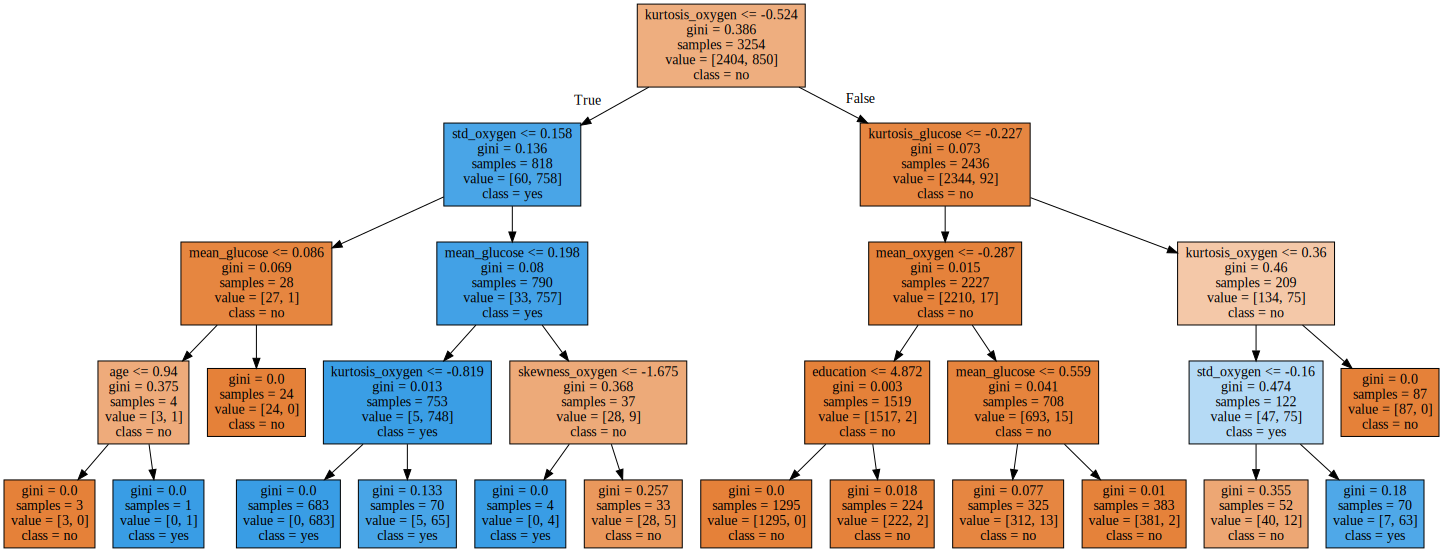

In [31]:
testDecissionTree('gini', 4, 1, None, None, np.random, 'random', X_train, y_train)

---------------------PARAMETERS---------------------
DecisionTreeClassifier(max_depth=8, min_samples_leaf=4,
                       random_state=<module 'numpy.random' from 'C:\\Users\\makoh\\anaconda3\\envs\\IAU\\lib\\site-packages\\numpy\\random\\__init__.py'>)
---------------------ACCURACY-----------------------
Accuracy:  0.8756715272448197
---------------------PRECISION----------------------
Micro-averaged precision:  0.8756715272448197
Macro-averaged precision:  0.8978240403304178
Per-class precision score: [0.85104167 0.94460641]
----------------------RECALL------------------------
Micro-averaged recall:  0.8756715272448197
Macro-averaged recall:  0.8978240403304178
Per-class recall score: [0.85104167 0.94460641]
----------------------F1-SCORE----------------------
Micro-averaged f1 score:  0.8756715272448197
Macro-averaged f1 score:  0.8548997772828508
Per-class f1 score: [0.90979955 0.8       ]


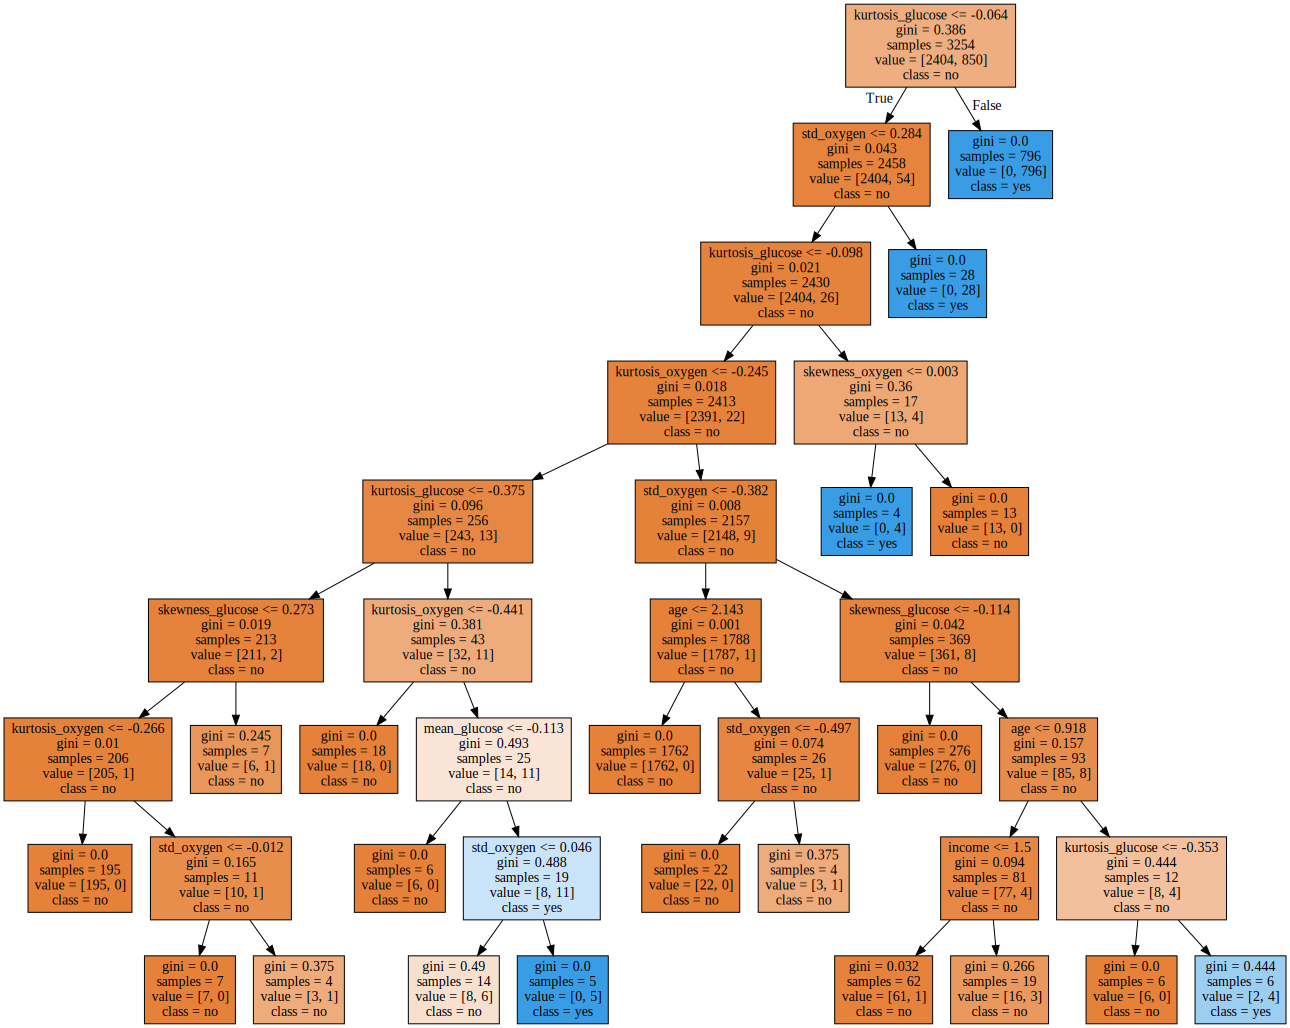

In [32]:
testDecissionTree('gini', 8, 4, None, None, np.random, 'best', X_train, y_train)

---------------------PARAMETERS---------------------
DecisionTreeClassifier(criterion='entropy', max_depth=1, splitter='random')
---------------------ACCURACY-----------------------
Accuracy:  0.9171143514965464
---------------------PRECISION----------------------
Micro-averaged precision:  0.9171143514965464
Macro-averaged precision:  0.8444393828960155
Per-class precision score: [0.99791667 0.6909621 ]
----------------------RECALL------------------------
Micro-averaged recall:  0.9171143514965464
Macro-averaged recall:  0.8444393828960155
Per-class recall score: [0.99791667 0.6909621 ]
----------------------F1-SCORE----------------------
Micro-averaged f1 score:  0.9171143514965464
Macro-averaged f1 score:  0.8805366529481278
Per-class f1 score: [0.94664032 0.81443299]


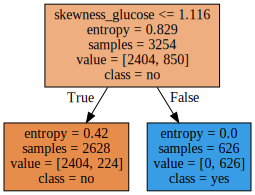

In [33]:
testDecissionTree('entropy', 1, 1, None, None, None, 'random', X_train, y_train)

---------------------PARAMETERS---------------------
DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       min_samples_leaf=3, splitter='random')
---------------------ACCURACY-----------------------
Accuracy:  0.8672294704528012
---------------------PRECISION----------------------
Micro-averaged precision:  0.8672294704528012
Macro-averaged precision:  0.858366739552964
Per-class precision score: [0.87708333 0.83965015]
----------------------RECALL------------------------
Micro-averaged recall:  0.8672294704528012
Macro-averaged recall:  0.858366739552964
Per-class recall score: [0.87708333 0.83965015]
----------------------F1-SCORE----------------------
Micro-averaged f1 score:  0.8672294704528012
Macro-averaged f1 score:  0.8379321773853201
Per-class f1 score: [0.90683899 0.76902537]


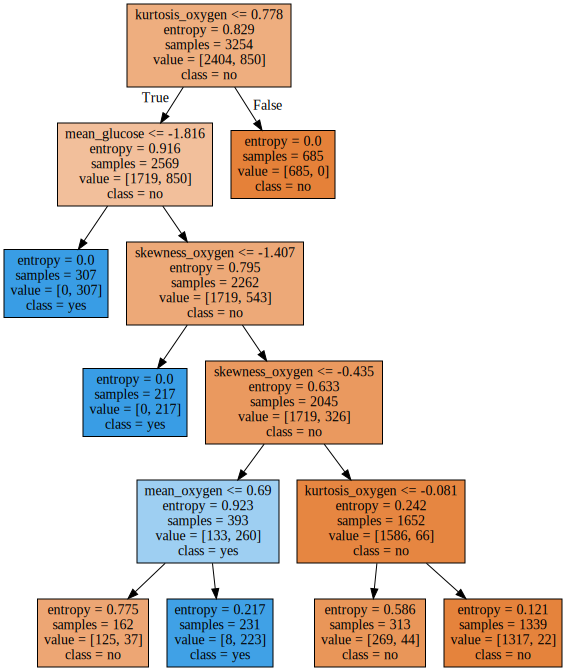

In [34]:
testDecissionTree('entropy', 5, 3, 'sqrt', None, None, 'random', X_train, y_train)

---------------------PARAMETERS---------------------
DecisionTreeClassifier(max_depth=3,
                       random_state=<module 'numpy.random' from 'C:\\Users\\makoh\\anaconda3\\envs\\IAU\\lib\\site-packages\\numpy\\random\\__init__.py'>)
---------------------ACCURACY-----------------------
Accuracy:  0.8779739063699156
---------------------PRECISION----------------------
Micro-averaged precision:  0.8779739063699156
Macro-averaged precision:  0.8984496477162294
Per-class precision score: [0.85520833 0.94169096]
----------------------RECALL------------------------
Micro-averaged recall:  0.8779739063699156
Macro-averaged recall:  0.8984496477162294
Per-class recall score: [0.85520833 0.94169096]
----------------------F1-SCORE----------------------
Micro-averaged f1 score:  0.8779739063699156
Macro-averaged f1 score:  0.8571000927710969
Per-class f1 score: [0.91171571 0.80248447]


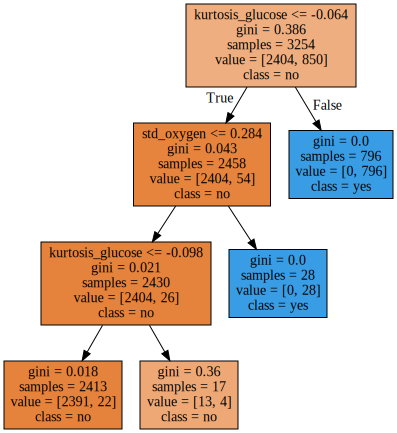

In [35]:
testDecissionTree('gini', 3, 1, None, None, np.random, 'best', X_train, y_train)

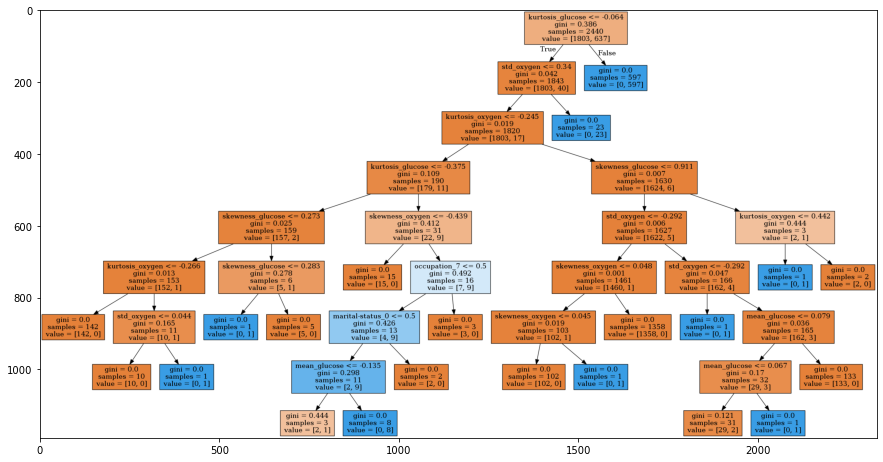

In [36]:
image = plt.imread('tree.png')
plt.figure(figsize = (15,15))
plt.imshow(image)

### Porovnanie natrenovaneho klasifikatora s nasimi pravidlami

Pri pozorovani sme zistili ze manualne pravidla volene nami maju lepsiu presnost ako natrenovany klasifikator. Natrenovany klasifikator dosahoval accuracy v priemere 0.86 zatial co nase pravidla dosiahli 0.95. Aj pri precision dosahuje nas strom lepsie vysledky 0.89, zatial co natrenovany klasifikator dosiahol v priemere 0.87. Recall dosiahol nas strom 0.89 a natrenovany klasifikator 0.86. F1 Score dosiahol nas strom 0.91 a natrenovany klasifikator 0.87. Po tomto pozorovani mozeme povedat ze nami urobeny strom dosahuje lepsie vysledky.

# Optimalizacia hyperparametrov

### Krizova validacia nad trenovacimi datami

Nacitanie a uprava datasetu

In [40]:
df1 = pd.read_csv("./data/personal_train.csv", index_col=0)
df2 = pd.read_csv("./data/other_train.csv", index_col=0)

X, y = prep_pip.one_proper_df(df1, df2)

In [41]:
PIP = prep_pip.get_preprocessing_pipeline()

In [42]:
X_cross, y_cross = PIP.fit_predict(X, y)

In [43]:
print(X_cross.shape)
print(y_cross.shape)

(3254, 33)
(3254,)


Ukazka 10 nasobnej krizovej validacie

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

cls = DecisionTreeClassifier(criterion='entropy')
scores = cross_val_score(cls, X_cross, y_cross, cv=10)
print(scores)
print(scores.mean())

[0.98466258 0.98773006 0.99693252 0.99079755 0.98769231 0.98769231
 0.98769231 0.98461538 0.97846154 0.98461538]
0.9870891930155734


{'whiskers': [<matplotlib.lines.Line2D at 0x2369c6decc8>,
 'caps': [<matplotlib.lines.Line2D at 0x2369c6d40c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2369c6d4648>],
 'medians': [<matplotlib.lines.Line2D at 0x2369c6d6148>],
 'fliers': [<matplotlib.lines.Line2D at 0x2369c6d6e88>],
 'means': []}

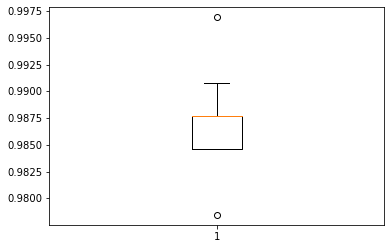

In [46]:
plt.boxplot(scores)

Vytvorili sme si grid, ktory otestuje vsetky permutacie zadanych hyperparametrov algoritmu CART pri pouziti 10 nasobnej krizovej validacie

In [48]:
SEED = 1

dt = DecisionTreeClassifier(random_state=SEED)

from sklearn.model_selection import GridSearchCV

params_dt = {
'criterion': ['gini', 'entropy'],    
'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
'min_samples_leaf': [0.02, 0.04, 0.06, 0.08, 0.1],
'max_features': [0.2, 0.4, 0.6, 0.8, 1]
}

grid_dt = GridSearchCV(estimator=dt,
param_grid=params_dt,
scoring=
'accuracy'
,
cv=10,
n_jobs=-1)

grid_dt.fit(X_cross, y_cross)


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'max_features': [0.2, 0.4, 0.6, 0.8, 1],
                         'min_samples_leaf': [0.02, 0.04, 0.06, 0.08, 0.1]},
             scoring='accuracy')

In [49]:
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'criterion': 'entropy', 'max_depth': 1, 'max_features': 0.2, 'min_samples_leaf': 0.02}


In [50]:
best_CV_score = grid_dt.best_score_
print('Best CV accuracy', format(best_CV_score))

Best CV accuracy 0.9830910806984428


In [51]:
best_model = grid_dt.best_estimator_

test_acc = best_model.score(X_valid,y_valid)

print("Test set accuracy of best model: {:.3f}".format(test_acc))

Test set accuracy of best model: 0.953


In [52]:
from scipy import stats

random_params = {
    'max_depth': stats.randint(1,12),
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': stats.randint(1,10)
}

In [53]:
from sklearn.model_selection import RandomizedSearchCV

random_optimization = RandomizedSearchCV(estimator = dt,param_distributions = random_params, 
                               n_iter = 10, scoring = 'f1_macro', cv = 5, verbose=True, random_state=42, n_jobs = -1)
random_optimization.fit(X_cross, y_cross)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002369A560B88>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002369A5D4BC8>},
                   random_state=42, scoring='f1_macro', verbose=True)

In [54]:
best_hyperparams = random_optimization.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 7}


In [55]:
best_CV_score = random_optimization.best_score_
print('Best CV accuracy', format(best_CV_score))

Best CV accuracy 0.9879187412156926


In [ ]:
best_model = random_optimization.best_estimator_

test_acc = best_model.score(X_valid,y_valid)

print("Test set accuracy of best model: {:.3f}".format(test_acc))

# Vyhodnotenie vplyvu zvolenej strategie riesenia chybajucich hodnot na spravnost klasifikacie